# Diabetes prediction: decision tree

## Notebook set-up

In [1]:
# Python standard library imports
import pickle

# PyPI imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

# Internal imports
import configuration as config
import functions as funcs

## 1. Data preparation

### 1.1. Load data from URL

In [2]:
url='https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
data_df=pd.read_csv(url)
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Inspect

In [3]:
data_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 1.3. Test-train split

In [6]:
# Do the test-train split
training_df, testing_df=train_test_split(
    data_df,
    test_size=0.25,
    random_state=315
)

## 2. EDA
### 2.1. Baseline model performance

In [7]:
training_df['Outcome'].value_counts()

Outcome
0    377
1    199
Name: count, dtype: int64

In [8]:
# Accuracy for constant '0' model
accuracy=((len(testing_df) - sum(testing_df['Outcome'])) / len(testing_df))*100
print(f'Testing accuracy of constant "0" model: {accuracy:.1f}%')

Testing accuracy of constant "0" model: 64.1%


In [9]:
logistic=LogisticRegression(max_iter=5000)
logistic.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy=accuracy_score(logistic.predict(testing_df.drop('Outcome', axis=1)), testing_df['Outcome'])*100
print(f'Testing accuracy of logistic regression model: {accuracy:.1f}%')


Testing accuracy of logistic regression model: 77.6%


## 2.2. Feature distributions and cleaning

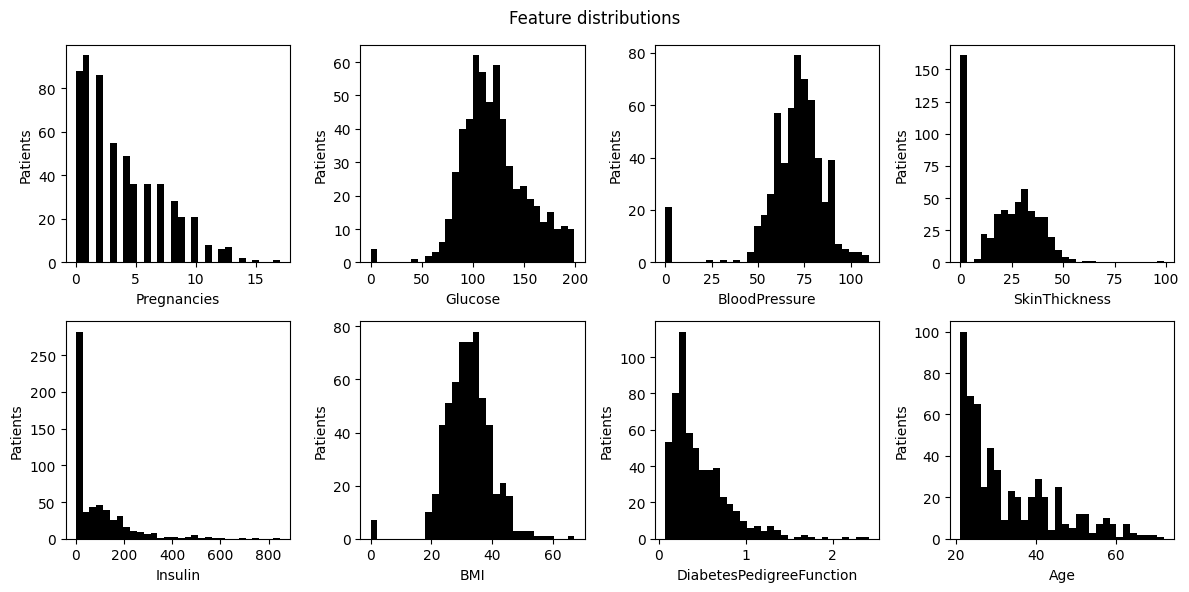

In [10]:
features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig, axs=plt.subplots(2,4, figsize=(12,6))
axs=axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(features):
    axs[i].hist(training_df[feature], color='black', bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Patients')

fig.tight_layout()

### 2.2.1. Zero counts

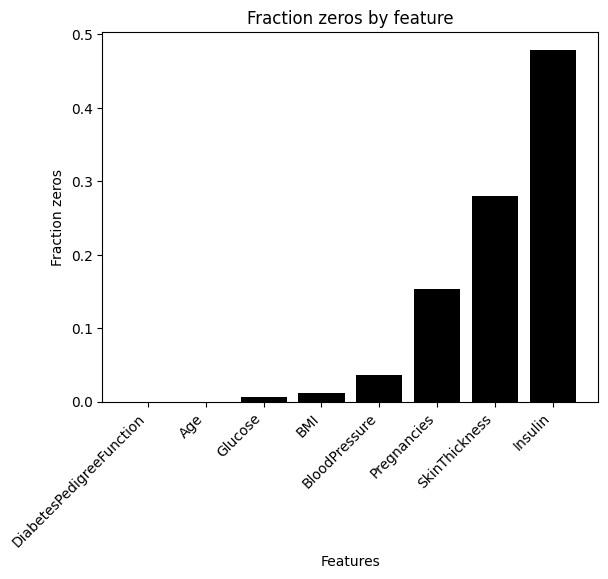

In [11]:
zero_fraction=(training_df[features] == 0).astype(int).sum(axis=0) / len(training_df)
zero_fraction.sort_values(inplace=True)

plt.title('Fraction zeros by feature')
plt.bar(zero_fraction.index, zero_fraction, color='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Fraction zeros')
plt.show()

### 2.2.2. Imputation of zeros

In [12]:
imputed_features=['Insulin','SkinThickness','BloodPressure','BMI','Glucose']
knn_imputer=KNNImputer(missing_values=0.0, weights='distance')
knn_imputer.fit(training_df[imputed_features])
training_df[imputed_features]=knn_imputer.transform(training_df[imputed_features])
testing_df[imputed_features]=knn_imputer.transform(testing_df[imputed_features])

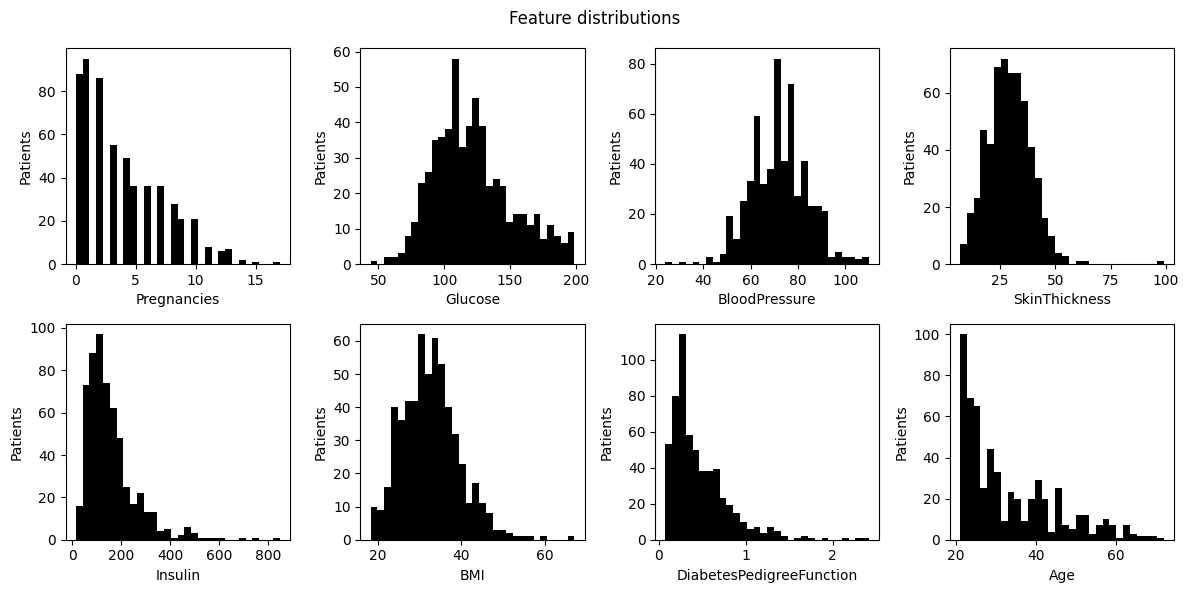

In [13]:
features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig, axs=plt.subplots(2,4, figsize=(12,6))
axs=axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(features):
    axs[i].hist(training_df[feature], color='black', bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Patients')

fig.tight_layout()

### 2.3. Feature interactions & selection

#### 2.3.1. Feature cross-correlations

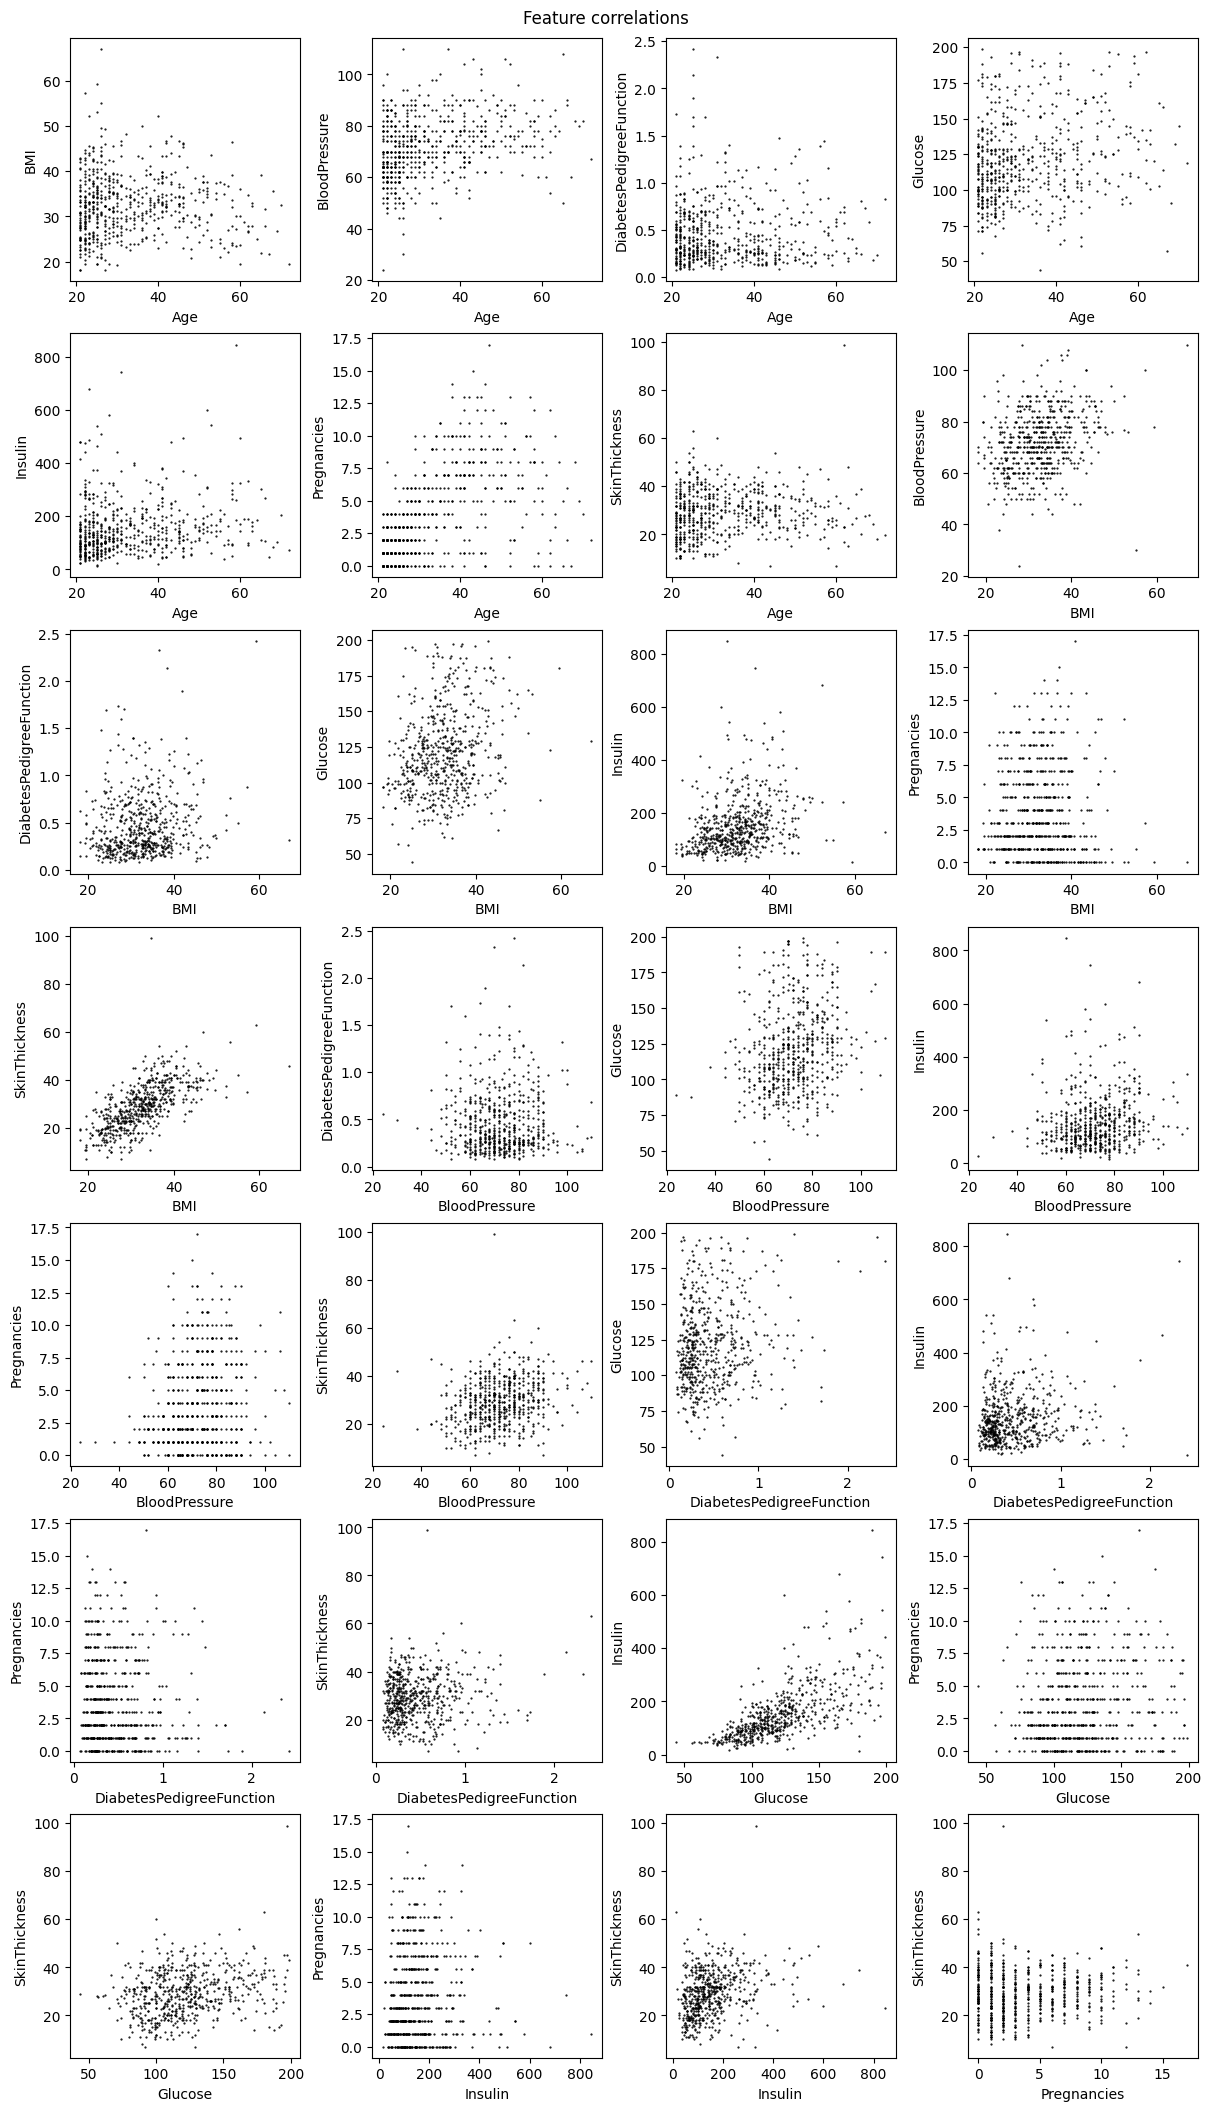

In [14]:
from itertools import combinations

feature_pairs=sorted(map(sorted, combinations(set(features), 2)))
rows=len(feature_pairs) // 4
fig, axs=plt.subplots(rows,4, figsize=(12,rows*3), layout='constrained')
axs=axs.flatten()

fig.suptitle('Feature correlations')

for i, feature_pair in enumerate(feature_pairs):
    axs[i].scatter(training_df[feature_pair[0]], training_df[feature_pair[1]], color='black', s=0.3)
    axs[i].set_xlabel(feature_pair[0])
    axs[i].set_ylabel(feature_pair[1])

#### 2.3.2. Feature-label interactions

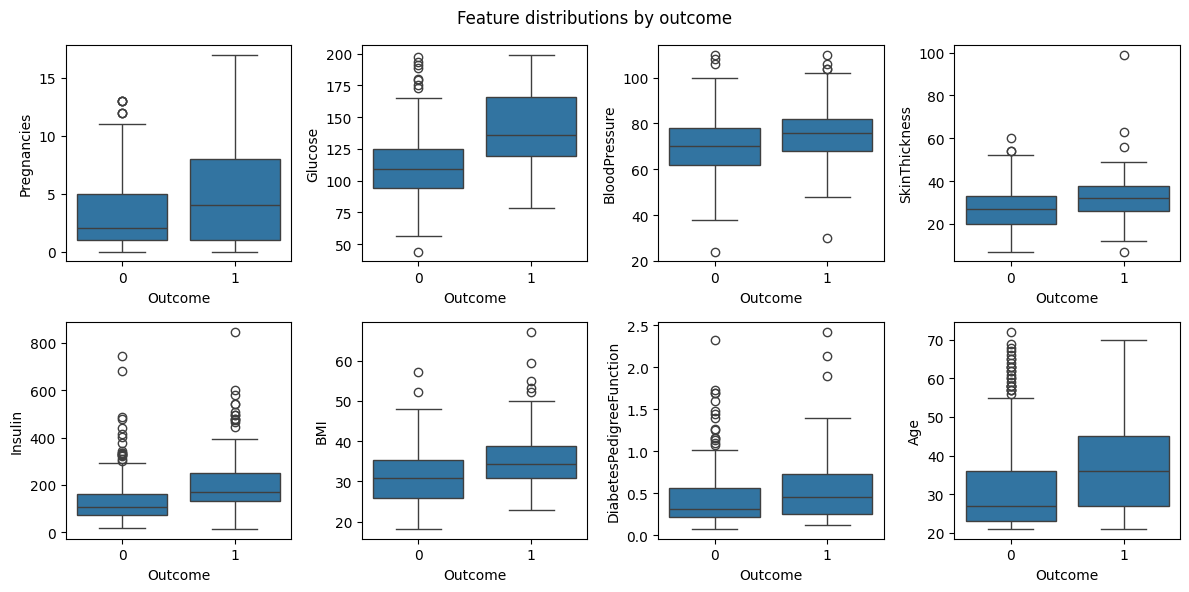

In [15]:
fig, axs=plt.subplots(2,4, figsize=(12,6))
axs=axs.flatten()

fig.suptitle('Feature distributions by outcome')

for i, feature in enumerate(features):

    sns.boxplot(training_df, x='Outcome', y=feature, ax=axs[i])

fig.tight_layout()

## 3. Baseline model

In [16]:
model=DecisionTreeClassifier(random_state=315)
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy=accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Accuracy of decision tree model: {accuracy:.1f}%')

Accuracy of decision tree model: 100.0%


In [17]:
cross_val_scores={
    'Model': [],
    'Score': []
}

scores=cross_val_score(
    DecisionTreeClassifier(random_state=315),
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 72.0 +/- 4.0%


## 4. Hyperparameter optimization

### 4.1. Hyperparameter grid search

In [18]:
%%time

hyperparameters={
    'criterion':['gini','entropy','log_loss'],
    'splitter':['best','random'],
    'max_depth':[2,4,8,16],
    'min_weight_fraction_leaf':[0.05,0.1,0.2],
    'max_features':[0.45,0.5,0.55],
    'min_impurity_decrease':[0,0.001,0.01,0.1],
    'ccp_alpha':[0.0,0.001,0.01,0.1]
}

search=GridSearchCV(
    DecisionTreeClassifier(random_state=315),
    hyperparameters,
    return_train_score=True,
    n_jobs=-1
)

search_results=search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 0.0
 criterion: gini
 max_depth: 8
 max_features: 0.5
 min_impurity_decrease: 0
 min_weight_fraction_leaf: 0.1
 splitter: best

CPU times: user 8.54 s, sys: 173 ms, total: 8.71 s
Wall time: 12.5 s


### 4.2. Hyperparameter optimization results

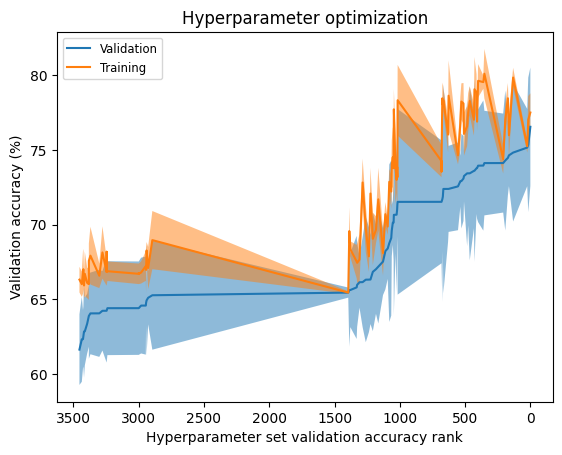

In [19]:
funcs.plot_cross_validation(search_results)

### 4.3. Cross-validation of optimized model

In [20]:
scores=cross_val_score(
    DecisionTreeClassifier(**search_results.best_params_, random_state=315),
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 76.6 +/- 4.0%


## 5. Evaluation

### 5.1. Model comparison

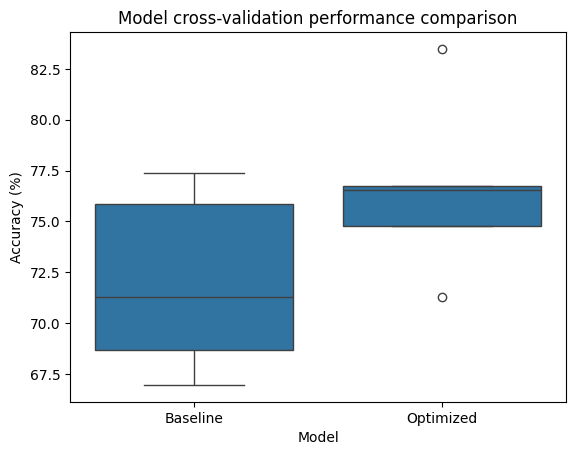

In [21]:
cross_val_scores=pd.DataFrame.from_dict(cross_val_scores)
sns.boxplot(cross_val_scores, x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 5.2. Test set performance

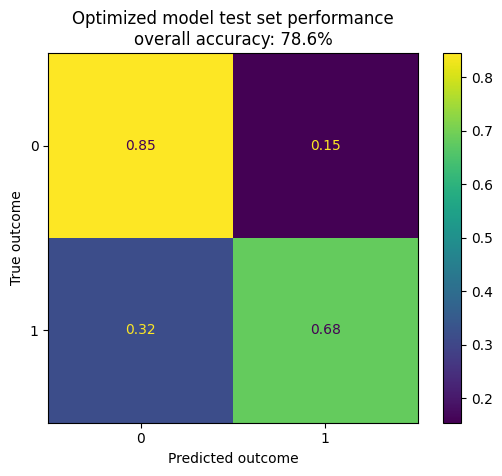

In [22]:
model=DecisionTreeClassifier(**search_results.best_params_, random_state=315)
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
testing_predictions=model.predict(testing_df.drop('Outcome', axis=1))

accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

# Plot the confusion matrix
cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 6. Save

### 6.1. Data

In [23]:
data={
    'training': training_df,
    'testing': testing_df
}

with open(config.DATA_FILE, 'wb') as output_file:
    pickle.dump(data, output_file)

### 6.2. Optimized hyperparameters

In [24]:
with open(config.DECISION_TREE_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(search_results.best_params_, output_file)

### 6.3. Model

In [25]:
with open(config.DECISION_TREE_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)